## 09 추천 시스템
### 01. 추천 시스템의 개요와 배경
1) 추천 시스템의 개요
- 추천시스템은 콘텐츠 기반 필터링 방식과 협업 필터링 방식으로 나뉨.
- 잠재요인 협업 필터링을 많이 사용하고 있으며 개인화 특성을 좀 더 강화하기 위해 하이브리드 형식으로 콘텐츠 기반과 협업 기반을 적절히 결합해 사용하는 경우가 늘고 있음.


### 03 최근접 이웃 협업 필터링
- 사용자가 아이템에 매긴 평점 정보나 상품 구매 이력과 같은 사용자 행동 양식만을 기반으로 추천을 수행하는 것이 협업 필터링 방식임.

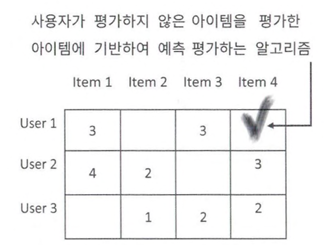

- 협업 필터링의 주요 목표는 사용자-아이템 평점 매트릭스와 같은 축적된 사용자 행동 데이터를 기반으로 사용자가 아직 평가하지 않은 아이템을 예측평가(Predicted Rating)하는 것임.
- 협업 필터링 알고리즘에 사용되는 사용자-아이템 평점 행렬에서 행은 개별 사용자, 열은 개별 아이템으로 구성되며 사용자 아이디 행, 아이템 아이디 열위치에 해당하는 값이 평점을 나타내는 형태가 되어야 함.
- 최근점 이웃 협업 필터링(메모리 협업 필터링):
  - 사용자 기반(user-user): 당신과 비슷한 고개들이 다음 상품도 구매
  - 아이템 기반: 이 상품을 선택한 다른 고객들은 다음 상품도 구매
  

---
### 04 잠재 요인 협업 필터링
2) 잠재 요인 협업 필터링의 이해
- 사용자-아이템 평점 행렬 데이터만을 이용해 '잠재 요인'을 끄집어 내는 것을 의미
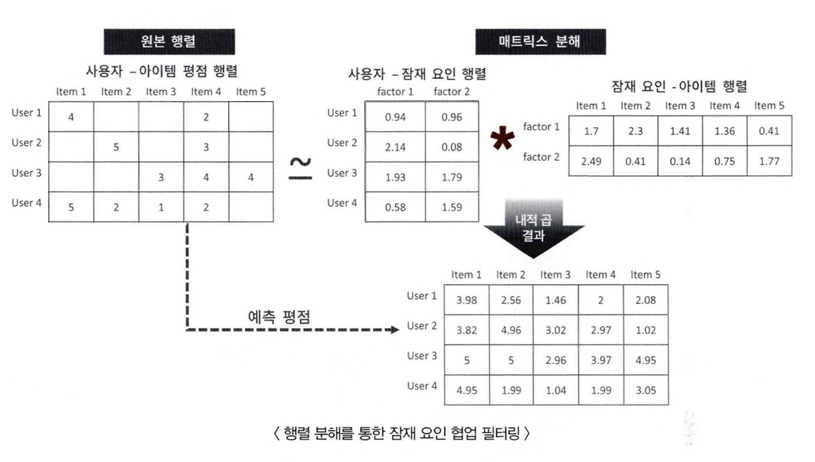

- R = P*Q.T
  - M은 총 사용자 수
  - N은 총 아이템 수
  - K는 잠재 요인의 차원 수
  - R은 M*N 차원의 사용자-아이템 평점행렬
  - P는 사용자와 잠재 요인과의 관계 값을 가지는 M*K 차원의 사용자-잠재요인 행렬
  - Q는 아이템과 잠재 요인과의 관계 값을 가지는 N*K 차원의 아이템-잠재요인 행렬
  - Q,T는 ,Q 매트릭스의 행과 열을 교환한 전치 행렬

3) 확률적 경사 하강법을 이용한 행렬 분해
- P와 Q행렬로 계산된 예측 R 행렬 값이 실제 R 행렬 값과 가장 최소의 오류를 가질 수 있도록 반복적인 비용 함수 최적화를 통해 P와 Q를 유추해 내는 것임.
- 과정:
  1. P와 Q를 임의의 값을 가진 행렬로 설정
  2. P와 Q,T 값을 곱해 예측 R 행렬을 게산하고 예측 R 행렬과 실제 R 행렬에 해당하는 오류 값을 계산
  3. 이 오류 값을 최소화할 수 있도록 P와 Q행렬을 적절한 값으로 각각 업데이트함.
  4. 만족할만한 오류값을 가질 때까지 2,3번 작업을 반복하면서 P와 Q값을 업데이트해 근사화

  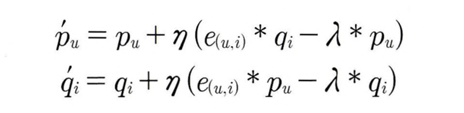

In [3]:
import numpy as np

# 원본 행렬 R 생성, 분해 행렬 P와 Q 초기화, 잠재 요인 차원 K는 3으로 설정
R = np.array([[4, np.nan, np.nan, 2, np.nan],
 [np.nan, 5, np.nan, 3, 1 ],
 [np.nan, np.nan, 3, 4, 4],
[5, 2, 1, 2, np.nan]])
num_users, num_items = R.shape
k=3

# P와 Q 행렬의 크기를 지정하고 정규 분포를 가진 임의의 값으로 입력
np.random.seed(1)
P = np.random.normal(scale=1./k, size=(num_users, k))
Q = np.random.normal(scale=1./k, size=(num_items, k))

In [4]:
# 실제 R 행렬과 예측 행렬의 오차를 구하는 get_rmse()함수를 만들어 보기
from sklearn.metrics import mean_squared_error

def get_rmse(R, P, Q, non_zeros):
  error= 0
  # 두 개의 분해된 행렬 P와 Q.T의 내적으로 예측 R 행렬 생성
  full_pred_matrix = np.dot(P,Q.T)

  # 실제 R 행렬에서 널이 아닌 값의 위치 인덱스 추출해 실제 R 행렬과 예측 행렬의 RMSE 추출
  x_non_zero_ind =  [non_zero[0] for non_zero in non_zeros]
  y_non_zero_ind = [non_zero[1] for non_zero in non_zeros]
  R_non_zeros = R[x_non_zero_ind, y_non_zero_ind]
  full_pred_matrix_non_zeros = full_pred_matrix[x_non_zero_ind, y_non_zero_ind]
  mse = mean_squared_error(R_non_zeros, full_pred_matrix_non_zeros)
  rmse = np.sqrt(mse)
  return rmse

In [6]:
# SGD 기반으로 행렬 분해 수행
# steps는 SGD를 반복해서 업데이트할 횟수를 의미, learning_rate=학습률, r_lambda=l2 regularization 계수
non_zeros = [(i, j, R[i, j]) for i in range(num_users) for j in range(num_items) if R[i, j] >0]
steps = 1000
learning_rate=0.01
r_lambda=0.01

# SGD 기법으로 P와 Q 매트릭스를 계속 업데이트.
for step in range(steps):
  for i, j, r in non_zeros:
    # 실제 값과 예측 값의 차이인 오류 값 구함
    eij = r - np.dot(P[i,:], Q[j,:].T)
    # Regularization을 반영한 SGD 업데이트 공식 적용
    P[i, :] = P[i, :] + learning_rate*(eij * Q[j, :] - r_lambda*P[i, :])
    Q[j, :] = Q[j, :] + learning_rate*(eij * P[i, :] - r_lambda*Q[j, :])

    rmse = get_rmse(R, P, Q, non_zeros)
    if (step%50) == 0:
      print('### iteration step: ', step, "rmse:", rmse)

### iteration step:  0 rmse: 3.261355059488935
### iteration step:  0 rmse: 3.26040057174686
### iteration step:  0 rmse: 3.253984404542389
### iteration step:  0 rmse: 3.2521583839863624
### iteration step:  0 rmse: 3.252335303789125
### iteration step:  0 rmse: 3.251072196430487
### iteration step:  0 rmse: 3.2492449982564864
### iteration step:  0 rmse: 3.247416477570409
### iteration step:  0 rmse: 3.241926055455223
### iteration step:  0 rmse: 3.2400454107613084
### iteration step:  0 rmse: 3.240166740749792
### iteration step:  0 rmse: 3.2388050277987723
### iteration step:  50 rmse: 0.5003190892212748
### iteration step:  50 rmse: 0.5001616291326989
### iteration step:  50 rmse: 0.49899601202578087
### iteration step:  50 rmse: 0.4988483450145831
### iteration step:  50 rmse: 0.49895189256631756
### iteration step:  50 rmse: 0.49833236830090993
### iteration step:  50 rmse: 0.4984148489378701
### iteration step:  50 rmse: 0.49792599580240876
### iteration step:  50 rmse: 0.49006

In [7]:
pred_matrix = np.dot(P, Q.T)
print('예측 행렬:\n', np.round(pred_matrix,3))

예측 행렬:
 [[3.991 0.897 1.306 2.002 1.663]
 [6.696 4.978 0.979 2.981 1.003]
 [6.677 0.391 2.987 3.977 3.986]
 [4.968 2.005 1.006 2.017 1.14 ]]
